# text assignment CO2

This is your final assignment. You'll get a lot of freedom in doing this assignment but that also means you have to make choices and explain the reasoning behind those choices in your report.


For this assignment you can use any dataset you can find from the [Our World in Data website](https://ourworldindata.org/)

Please formulate an answer to the following three questions in your report.

1. What is the biggest predictor of a large CO2 output per capita of a country?
2. which countries are making the biggest strides in decreasing CO2 output?
3. which non-fossil fuel energy technology will have the best price in the future?


1. Biggest predictor of CO2 output

To determine this you may want to consider things like GDP per capita, diets, number of cars per capita, various energy source, mobility and other factors.

Your answer can also be a specific combination of certain factors.


2. Biggest strides in decreasing CO2 output

You'll need to find the relative CO2 output for each country to be able to calculate this. But countries can have growing and shrinking populations too, so it's probably a good idea to take this into account as well.


3. Best future price for non-fossil fuel energy

To be able to predict prices you'll probably need to use linear regression over the various non-fossil fuel options.

# Installations

In [ ]:
pip install fpdf

# imports

In [ ]:
import numpy as np
import numpy.polynomial.polynomial as poly # import voor regressielijn
from functools import reduce
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.mathtext import FontProperties
from matplotlib.layout_engine import ConstrainedLayoutEngine
import missingno as msno
from sklearn.impute import KNNImputer # import voor KNN imputation
from sklearn.cluster import KMeans
from fpdf import FPDF
from scipy.stats import pearsonr
from scipy.stats import shapiro
from scipy.stats import lognorm

In [ ]:
# %load_ext google.colab.data_table

# Dataframe

## Raw dataframes

In [ ]:
url_co2_data = "https://raw.githubusercontent.com/PetraHartman/module_7/main/owid-co2-data.csv"
df_co2_data = pd.read_csv(url_co2_data, encoding = "iso-8859-1")
# display (df_co2_data)

In [ ]:
url_energy_cost = "https://raw.githubusercontent.com/PetraHartman/module_7/main/levelized-cost-of-energy.csv"
df_energy_cost = pd.read_csv(url_energy_cost, encoding = "iso-8859-1")
display(df_energy_cost)

,Entity,Code,Year,Bioenergy levelized cost of energy,Geothermal levelized cost of energy,Offshore wind levelized cost of energy,Solar photovoltaic levelized cost of energy,Concentrated solar power levelized cost of energy,Hydropower levelized cost of energy,Onshore wind levelized cost of energy
0,Australia,AUS,2010,NaN,NaN,NaN,0.423957,NaN,NaN,NaN
1,Australia,AUS,2011,NaN,NaN,NaN,0.430691,NaN,NaN,NaN
2,Australia,AUS,2012,NaN,NaN,NaN,0.261030,NaN,NaN,NaN
3,Australia,AUS,2013,NaN,NaN,NaN,0.150157,NaN,NaN,NaN
4,Australia,AUS,2014,NaN,NaN,NaN,0.123621,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
481,World,OWID_WRL,1995,NaN,NaN,NaN,NaN,NaN,NaN,0.207732
482,World,OWID_WRL,1996,NaN,NaN,NaN,NaN,NaN,NaN,0.185732
483,World,OWID_WRL,1997,NaN,NaN,NaN,NaN,NaN,NaN,0.163131
484,World,OWID_WRL,1998,NaN,NaN,NaN,NaN,NaN,NaN,0.152881


## Modified dataframes

### 1.What is the biggest predictor of a large CO2 output per capita of a country?

In [ ]:
# keep columns
capita_columns = [col for col in df_co2_data if "capita" in col]
# print(capita_columns)
# df_co2_data.info()
df_co2_data_predictor_a = df_co2_data[["country", "year", "iso_code", "gdp", "population"]]
df_co2_data_predictor_b = df_co2_data[capita_columns]
df_predictor = pd.concat([df_co2_data_predictor_a, df_co2_data_predictor_b],
                               axis = 1)

# capitalize column names
df_predictor.columns = [s.capitalize() for s in df_predictor.columns]

# change column names
df_predictor.columns = df_predictor.columns.str.replace("_", " ")
df_predictor.columns = df_predictor.columns.str.replace("per capita", "(per capita)")
df_predictor.columns = df_predictor.columns.str.replace("co2", "CO2")
df_predictor.columns = df_predictor.columns.str.replace("Co2", "CO2")

# add gdp per catipa
if "GDP (per capita)" not in df_predictor:
  df_predictor['GDP (per capita)'] = df_predictor["Gdp"] / df_predictor["Population"]

# drop columns because combined are CO2 including luc (per capita)
df_predictor = df_predictor.drop("CO2 (per capita)", axis = 1)
df_predictor = df_predictor.drop("Land use change CO2 (per capita)", axis = 1)
# drop column because is similar to Ghg (per capita)
df_predictor = df_predictor.drop("Ghg excluding lucf (per capita)", axis = 1)

df_predictor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50598 entries, 0 to 50597
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Country                         50598 non-null  object 
 1   Year                            50598 non-null  int64  
 2   Iso code                        42142 non-null  object 
 3   Gdp                             14564 non-null  float64
 4   Population                      40008 non-null  float64
 5   Cement CO2 (per capita)         22714 non-null  float64
 6   CO2 including luc (per capita)  23696 non-null  float64
 7   Coal CO2 (per capita)           24421 non-null  float64
 8   Consumption CO2 (per capita)    4227 non-null   float64
 9   Energy (per capita)             10320 non-null  float64
 10  Flaring CO2 (per capita)        24272 non-null  float64
 11  Gas CO2 (per capita)            24340 non-null  float64
 12  Ghg (per capita)                

In [ ]:
# drop NaN values
df_predictor = df_predictor.dropna()
# display(df_predictor)

### 2.Which countries are making the biggest strides in decreasing CO2 output?

In [ ]:
df_co2_data_reduction = pd.read_csv(url_co2_data, encoding = "iso-8859-1")
# display (df_co2_data_reduction.info())


### 3.Which non-fossil fuel energy technology will have the best price in the future?

In [ ]:
df_energy_cost = df_energy_cost.sort_values(by = ["Year"])
# display(df_energy_cost)
df_energy_cost_world = df_energy_cost.groupby("Entity").get_group("World")
# display(df_energy_cost_world)

# Analysis

## 1.What is the biggest predictor of a large CO2 output per capita of a country?

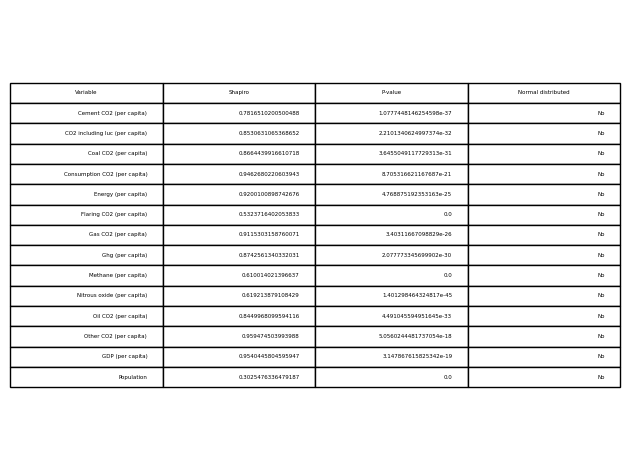

In [ ]:
def shapiro_wilk():
  capita_columns = [col for col in df_predictor if "capita" in col]
  df_normal = pd.DataFrame(columns = ["Variable"])
  for name in capita_columns:
       a = df_predictor[capita_columns[0]]
       b = df_predictor[name]
       shapiro_wilk = shapiro(b)
       shapiro_value = shapiro_wilk[0]
       p_value = shapiro_wilk[1]

       if p_value < 0.05:  # if p-value is smaller than 0.05 the data is not distributed normal.
          normal = "No"
       else:
          normal = "Yes"
       row = {"Variable" : name, "Shapiro" : shapiro_value, "P-value" : p_value, "Normal distributed": normal}
       df_row = pd.DataFrame(row, index=[0])
       df_normal = pd.concat([df_normal, df_row])
  if "Population" in df_predictor:
       a = df_predictor[capita_columns[0]]
       b = df_predictor["Population"]
       shapiro_wilks = shapiro(b)
       shapiro_value = shapiro_wilks[0]
       p_value = shapiro_wilks[1]

       if p_value < 0.05:  # if p-value is smaller than 0.05 the data is not distributed normal.
          normal = "No"
       else:
          normal = "Yes"
       row = {"Variable" : "Population", "Shapiro" : shapiro_value, "P-value" : p_value, "Normal distributed": normal}
       df_row = pd.DataFrame(row, index=[0])
       df_normal = pd.concat([df_normal, df_row])
  return(df_normal)

df_shapiro = shapiro_wilk()
df_shapiro
# none of the data is distrubuted normal.


fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText = df_shapiro.values, colLabels = df_shapiro.columns, loc = "center")
fig.tight_layout()
plt.savefig("shapiro.png", transparent = False, facecolor = "white", bbox_inches = "tight")

In [ ]:
# normalize data
capita_columns = [col for col in df_predictor if "capita" in col]
df_predictor_normalized = pd.DataFrame(columns =[])
for name in capita_columns:
    df_predictor_normalized[name] = np.cbrt(df_predictor[name])
df_predictor_normalized["Population"] = np.cbrt(df_predictor["Population"])
display(df_predictor_normalized)

,Cement CO2 (per capita),CO2 including luc (per capita),Coal CO2 (per capita),Consumption CO2 (per capita),Energy (per capita),Flaring CO2 (per capita),Gas CO2 (per capita),Ghg (per capita),Methane (per capita),Nitrous oxide (per capita),Oil CO2 (per capita),Other CO2 (per capita),GDP (per capita),Population
3738,0.587713,2.490632,2.026481,2.425197,39.278112,0.753025,1.264315,3.166745,2.022659,1.674831,1.733699,0.509164,30.083205,257.369945
3739,0.568773,2.373256,2.037461,2.416952,39.010173,0.739864,1.238128,3.153025,2.013163,1.660569,1.722313,0.505277,29.885572,258.487730
3740,0.550688,2.610803,2.048244,2.416609,39.079283,0.747697,1.248264,3.142731,1.996159,1.648269,1.713957,0.512993,30.134200,259.439126
3741,0.553966,2.658251,2.041867,2.411977,39.224853,0.739864,1.264732,3.136814,1.982853,1.640998,1.724221,0.526564,30.511951,260.273450
3742,0.580879,2.606149,2.040988,2.430965,39.597129,0.728108,1.276501,3.137965,1.981156,1.634161,1.728359,0.551785,30.939538,261.126796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48151,0.495968,2.584873,1.744719,2.627615,43.218482,0.583827,1.645565,2.618167,1.276910,0.933702,1.911016,0.465701,37.128600,685.436490
48152,0.497319,2.552644,1.657784,2.613539,42.965786,0.585777,1.656692,2.593871,1.274247,0.929862,1.916568,0.457886,37.342038,687.257740
48153,0.494609,2.532223,1.602989,2.586817,42.838322,0.550688,1.654381,2.598915,1.259081,0.934847,1.915478,0.444796,37.432749,689.089472
48154,0.495968,2.519895,1.583157,2.575711,42.779292,0.564622,1.642111,2.583924,1.266397,0.932170,1.914660,0.437952,37.646732,690.896567


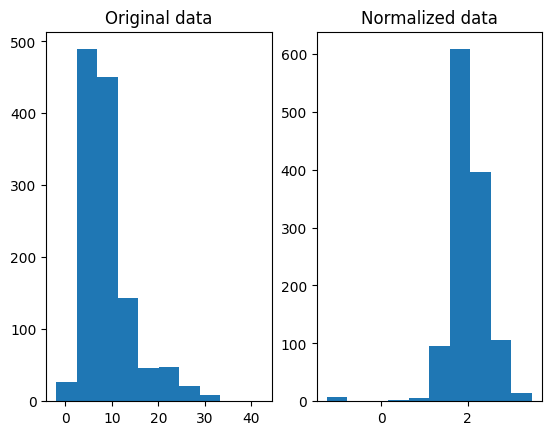

In [ ]:
example_predictor_original = df_predictor["CO2 including luc (per capita)"]
example_predictor_normalized = df_predictor_normalized["CO2 including luc (per capita)"]

fig, ax = plt.subplots(nrows = 1, ncols = 2)

ax[0].hist(example_predictor_original)
ax[1].hist(example_predictor_normalized)
ax[0].set_title("Original data")
ax[1].set_title("Normalized data")
plt.savefig("histograms_original_normalized.png", transparent = False, facecolor = "white", bbox_inches = "tight")

In [ ]:
# find correlation between total co2 per capita and parts of total co2 per capita
capita_columns = [col for col in df_predictor_normalized if "capita" in col]
# display (capita_columns)
df_pearsonr = pd.DataFrame(columns = ["Column name", "Pearsonr", "P-value"])
# for columns with capita in the name
for column in capita_columns:
  pearson_r_value = pearsonr(df_predictor_normalized["CO2 including luc (per capita)"], df_predictor_normalized[column])
  n = len(df_predictor_normalized[column])
  row = {"Column name" : column, "Pearsonr" : pearson_r_value[0], "P-value" : pearson_r_value[1], "N" : n}
  # display(row)
  df_row = pd.DataFrame(row, index = [0])
  df_pearsonr = pd.concat([df_pearsonr, df_row])
# for population
pearson_r_value = pearsonr(df_predictor_normalized["CO2 including luc (per capita)"], df_predictor_normalized["Population"])
n = len(df_predictor_normalized["Population"])
row = {"Column name" : "Population", "Pearsonr" : pearson_r_value[0], "P-value" : pearson_r_value[1], "N" : n}
df_row = pd.DataFrame(row, index = [0])
df_pearsonr = pd.concat([df_pearsonr, df_row])
# only use significant values (P>0.05) and sort descending
df_pearsonr = df_pearsonr[df_pearsonr["P-value"] <0.05].sort_values("Pearsonr", ascending = False)

display (df_pearsonr)

,Column name,Pearsonr,P-value,N
0,CO2 including luc (per capita),1.000000,0.000000e+00,1234.0
0,Ghg (per capita),0.708574,9.076986e-189,1234.0
0,Energy (per capita),0.649021,1.772052e-148,1234.0
0,Consumption CO2 (per capita),0.590877,4.948759e-117,1234.0
0,Oil CO2 (per capita),0.514715,2.004394e-84,1234.0
0,Coal CO2 (per capita),0.512911,9.489299e-84,1234.0
0,Other CO2 (per capita),0.444679,5.828080e-61,1234.0
0,GDP (per capita),0.404831,7.283317e-50,1234.0
0,Gas CO2 (per capita),0.399292,1.947627e-48,1234.0
0,Methane (per capita),0.345132,7.690012e-36,1234.0


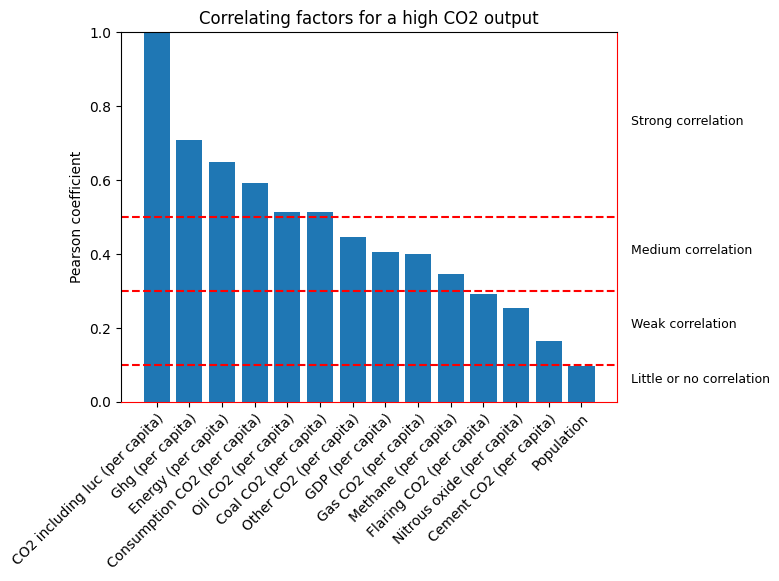

In [ ]:
fig, ax = plt.subplots()

side_text_distance = len(df_pearsonr["Column name"]) + 0.5

reverence = df_pearsonr ["Column name"]
pearsonr_values = df_pearsonr["Pearsonr"]
ax.bar(reverence, pearsonr_values)
plt.xticks(rotation = 45, ha = "right", rotation_mode = "anchor")

ax.set_ylabel("Pearson coefficient")
# ax.set_title("Correlating factors for a high CO2 output")
ax.set_ylim(0,1)


plt.axhline(y=0.1, color="red", linestyle="--")
plt.axhline(y=0.3, color="red", linestyle="--")
plt.axhline(y=0.5, color="red", linestyle="--")
ax.spines["right"].set_color("red")
ax.spines["bottom"].set_color("red")

plt.text(side_text_distance, 0.05, "Little or no correlation", fontsize = 9)
plt.text(side_text_distance, 0.2, "Weak correlation", fontsize = 9)
plt.text(side_text_distance, 0.4, "Medium correlation", fontsize = 9)
plt.text(side_text_distance, 0.75, "Strong correlation", fontsize = 9)

plt.savefig("correlating_factors.png", transparent = False, facecolor = "white", bbox_inches = "tight")


In [ ]:
# top 3 correlating factors for a high CO2 output are:
correlating_factor_1 = df_pearsonr.iloc[1, 0]
correlating_factor_2 = df_pearsonr.iloc[2, 0]
correlating_factor_3 = df_pearsonr.iloc[3, 0]

## 2.which countries are making the biggest strides in decreasing CO2 output?

In [ ]:
# kept iso_code column so i could filter out nan (not countries.)
df_co2_reduction = df_co2_data[["country",
                                "iso_code",
                                "year",
                                "population",
                                "co2"]]
# drop NaN
df_co2_reduction = df_co2_reduction.dropna()
# display(df_co2_reduction)

"Datapoint 24330 of Kuwait in 1991 has an extreme value of 5x the rest of the measurements. assumed to be a wrong datapoint and will be removed "
df_co2_reduction = df_co2_reduction.drop(24360)

In [ ]:
def population_year():
    year_list = pd.unique(df_co2_reduction["year"])
    grp_data = df_co2_reduction.groupby(["year"])
    df_pop_year = pd.DataFrame(columns = ["Year", "Population", "CO2", "Number of contributing countries"])
    for year in year_list:
        if year not in df_pop_year:
           length = len (grp_data.get_group(year))
           sum_pop = grp_data.get_group(year)["population"].sum(axis=0)
           sum_co2 = grp_data.get_group(year)["co2"].sum(axis=0)

           row = {"Year" : [year], "Population" : [sum_pop], "CO2" : sum_co2, "Number of contributing countries" : [length]}
           df_row = pd.DataFrame(row)
           df_pop_year = pd.concat([df_pop_year, df_row], axis = 0)

           df_pop_year["Number of contributing countries"]= df_pop_year["Number of contributing countries"].astype(int)
    return (df_pop_year)

df_info_year = population_year()

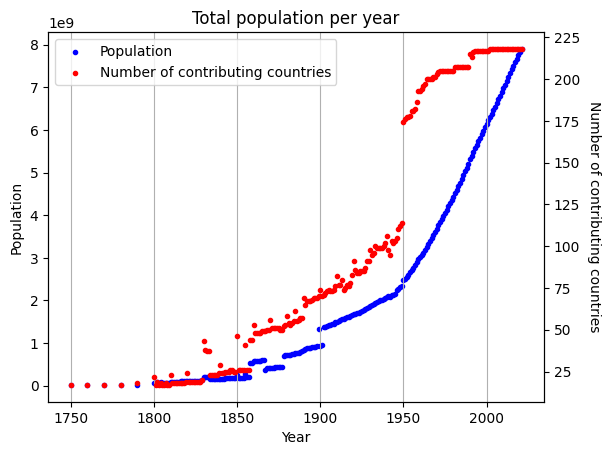

In [ ]:
def total_population_year_graph():
    fig, ax = plt.subplots()
    ax1 = ax.twinx()
    ax.scatter(df_info_year["Year"], df_info_year["Population"], color = "blue", marker = ".", label = "Population")
    ax1.scatter(df_info_year["Year"], df_info_year["Number of contributing countries"], color = "red", marker = ".", label = "Number of contributing countries")

    # ax.set_title("Total population per year")
    ax.set_xlabel("Year")
    ax.set_ylabel("Population")
    ax1.set_ylabel("Number of contributing countries", rotation = -90, labelpad = 15)
    ax.xaxis.grid(True)

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax1.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc=0)

    plt.show

total_population_year_graph()

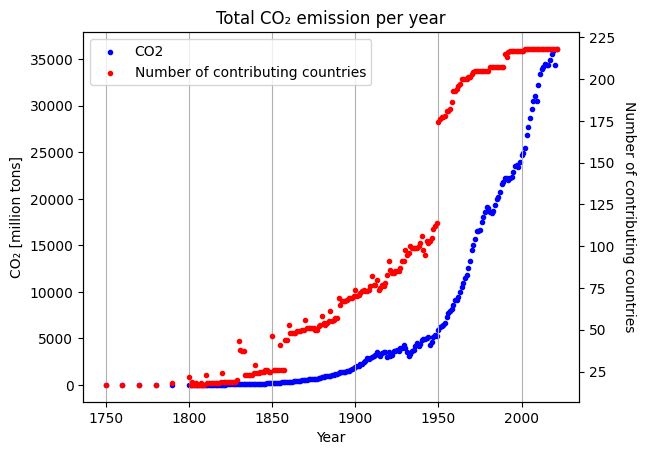

In [ ]:
def total_emission_year_graph():
    fig, ax = plt.subplots()
    ax1 = ax.twinx()
    ax.scatter(df_info_year["Year"], df_info_year["CO2"], color = "blue", marker = ".", label = "CO2")
    ax1.scatter(df_info_year["Year"], df_info_year["Number of contributing countries"], color = "red", marker = ".", label = "Number of contributing countries")

    # ax.set_title("Total CO\u2082 emission per year")
    ax.set_xlabel("Year")
    ax.set_ylabel("CO\u2082 [million tons]")
    ax1.set_ylabel("Number of contributing countries", rotation = -90, labelpad = 15)
    ax.xaxis.grid(True)

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax1.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc=0)

    return plt.savefig("total_emission_per_year.png", transparent = False, facecolor = "white", bbox_inches = "tight")

graph_total_emission_year = total_emission_year_graph()

In [ ]:
def co2_difference ():
    df_co2_reduction.sort_values(by="year")
    df_co2_reduction["co2_capita"] =co2_capita = df_co2_reduction["co2"]/df_co2_reduction["population"] * 1000000 # in ton CO2

    country_group = df_co2_reduction.groupby("country")
    df_co2_difference = pd.DataFrame(columns = ["Country",
                                                "Year end",
                                                "Population end",
                                                "CO2 max [million tons]",
                                                "CO2 end [million tons]",
                                                "CO2 difference [%]",
                                                "CO2 max per capita [tons]",
                                                "CO2 end per capita [tons]",
                                                "CO2 difference per capita [%]",
                                                "Number of measurements"])
    country_list = df_co2_reduction.country.unique()

    for country in country_list:
        country_data = country_group.get_group(country)
        year_end = country_data["year"].iloc[-1]  # Year of last measurement
        pop_end = country_data["population"].iloc[-1]  # population in year of last measurement
        max_co2 = country_data["co2"].max()  # Maximum CO2 output
        end_co2 = country_data["co2"].tail(1)  # Last meaurement for CO2 output
        difference_co2 = (end_co2 - max_co2) / end_co2 * 100  # Percentage of difference in output between the maximum value and the last measured value
        max_co2_capita = country_data["co2_capita"].max()  # Maximum CO2 output per capita
        end_co2_capita = country_data["co2_capita"].tail(1)  # Last meaurement for CO2 output per capita
        difference_co2_capita = (end_co2_capita - max_co2_capita) / end_co2_capita * 100  # Percentage of difference in output per capita between the maximum value and the last measured value
        contribution = len(country_data)  # number of measurements

        row = {"Country": country,
               "Year end": year_end,
               "Population end": pop_end,
               "CO2 max [million tons]" : max_co2,
               "CO2 end [million tons]" : end_co2,
               "CO2 difference [%]" : difference_co2,
               "CO2 max per capita [tons]": max_co2_capita,
               "CO2 end per capita [tons]": end_co2_capita,
               "CO2 difference per capita [%]" : difference_co2_capita,
               "Number of measurements" : contribution}
        df_row = pd.DataFrame(row)
        df_co2_difference = pd.concat([df_co2_difference, df_row], axis = 0)
    return(df_co2_difference)

df_co2_difference = co2_difference()

In [ ]:
co2_difference_top_5_percentage = df_co2_difference.nsmallest(5, "CO2 difference [%]").sort_values("CO2 difference [%]", ascending = True)
co2_capita_difference_top_5_percentage = df_co2_difference.nsmallest(5, "CO2 difference per capita [%]").sort_values("CO2 difference per capita [%]", ascending = True)

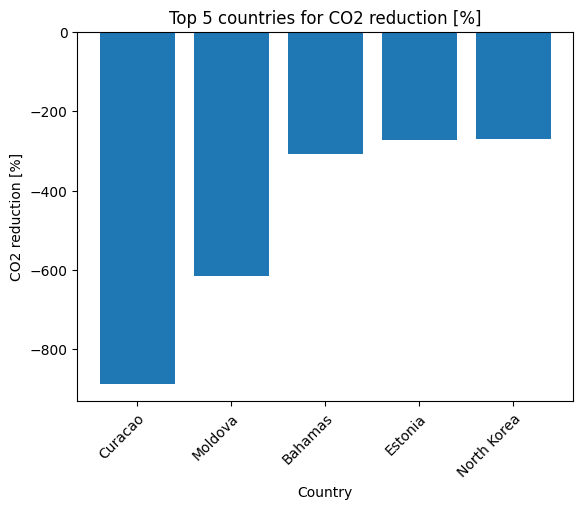

In [ ]:
fig, ax = plt.subplots()
x = co2_difference_top_5_percentage["Country"]
y = co2_difference_top_5_percentage["CO2 difference [%]"]

ax.bar(x,y)
ax.set_xlabel("Country")
ax.set_ylabel("CO2 reduction [%]")
# ax.set_title("Top 5 countries for CO2 reduction [%]")
plt.xticks(rotation = 45, ha = "right", rotation_mode = "anchor")
plt.savefig("graph_reduction_%.png", transparent = False, facecolor = "white", bbox_inches = "tight")

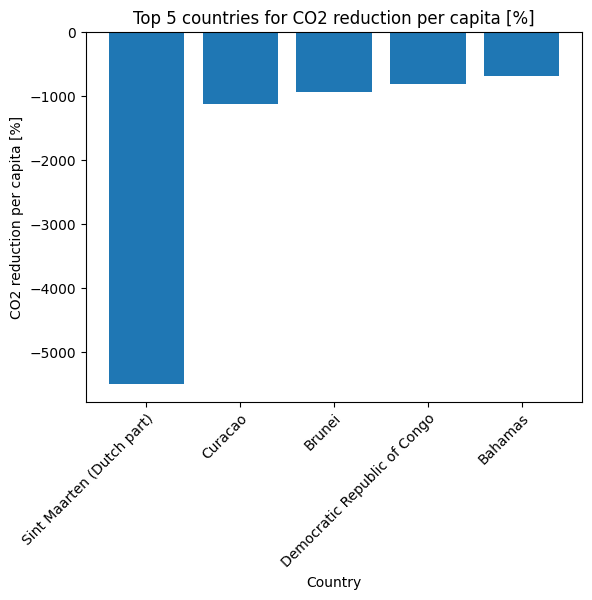

In [ ]:
fig, ax = plt.subplots()
x = co2_capita_difference_top_5_percentage["Country"]
y = co2_capita_difference_top_5_percentage["CO2 difference per capita [%]"]

ax.bar(x,y)
ax.set_xlabel("Country")
ax.set_ylabel("CO2 reduction per capita [%]")
# ax.set_title("Top 5 countries for CO2 reduction per capita [%]")
plt.xticks(rotation = 45, ha = "right", rotation_mode = "anchor")
plt.savefig("graph_reduction_capita_%.png", transparent = False, facecolor = "white", bbox_inches = "tight")

In [ ]:
best_performing = pd.merge(co2_capita_difference_top_5_percentage, co2_difference_top_5_percentage, how='inner', left_on='Country', right_on='Country')

display(best_performing)
best_performing_1 =  best_performing.iloc[0, 0]
best_performing_2 = best_performing.iloc[1,0]
display(best_performing_1)
display(best_performing_2)

,Country,Year end_x,Population end_x,CO2 max [million tons]_x,CO2 end [million tons]_x,CO2 difference [%]_x,CO2 max per capita [tons]_x,CO2 end per capita [tons]_x,CO2 difference per capita [%]_x,Number of measurements_x,Year end_y,Population end_y,CO2 max [million tons]_y,CO2 end [million tons]_y,CO2 difference [%]_y,CO2 max per capita [tons]_y,CO2 end per capita [tons]_y,CO2 difference per capita [%]_y,Number of measurements_y
0,Curacao,2021,190348.0,18.193,1.844,-886.605206,118.279479,9.687520,-1120.946974,72,2021,190348.0,18.193,1.844,-886.605206,118.279479,9.687520,-1120.946974,72
1,Bahamas,2021,407920.0,9.709,2.386,-306.915339,46.114753,5.849186,-688.396054,72,2021,407920.0,9.709,2.386,-306.915339,46.114753,5.849186,-688.396054,72


'Curacao'

'Bahamas'

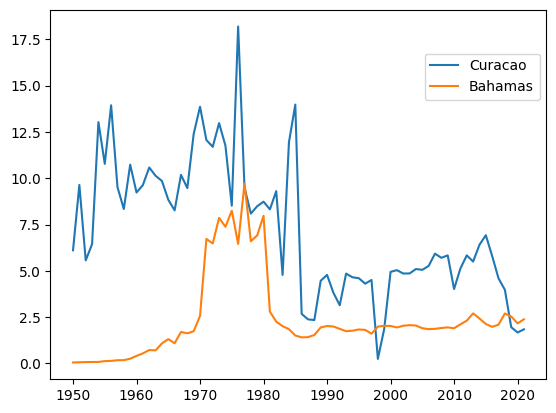

In [ ]:
# visual check for strange datapoints in dataset.

country_group = df_co2_reduction.groupby("country")
country_data1 = country_group.get_group(best_performing_1)
country_data2= country_group.get_group(best_performing_2)

fig, ax = plt.subplots()
x1 = country_data1["year"]
x2 = country_data2["year"]
y1 = country_data1["co2"]
y2 = country_data2["co2"]
handles = [best_performing_1, best_performing_2]

ax.plot(x1,y1)
ax.plot(x2,y2)

ax.legend(handles, bbox_to_anchor = (1, 0.9))

## 3.Which non-fossil fuel energy technology will have the best price in the future?

In [ ]:
# extrapolate data with KNNearest
def extrapolate(source):
  df_cost_extrapolated = df_energy_cost_world.copy()
  df_source = df_cost_extrapolated[["Year", source]]
  df_source = df_source.dropna()
  range_years =  range(2022,2031) # not specified how far in the future
  for y in range_years:
      row = {"Year" : [y]}
      df_row = pd.DataFrame(row)
      df_source = pd.concat([df_source, df_row], axis = 0)
      imputer = KNNImputer(n_neighbors=5) # 5 = standard value
      df_source = imputer.fit_transform(df_source)
      df_source = pd.DataFrame(df_source, columns = ["Year", source])

  return (df_source)

# produce different extrapolated dataframes
bio = (extrapolate("Bioenergy levelized cost of energy"))
geo = (extrapolate("Geothermal levelized cost of energy"))
offshore = (extrapolate("Offshore wind levelized cost of energy"))
solar_voltaic = (extrapolate("Solar photovoltaic levelized cost of energy"))
concentrated_solar = (extrapolate("Concentrated solar power levelized cost of energy"))
hydropower = (extrapolate("Hydropower levelized cost of energy"))
onshore = (extrapolate("Onshore wind levelized cost of energy"))

# merge the diffent dataframes
dataframes_sources = [bio, geo, offshore, solar_voltaic, concentrated_solar, hydropower, onshore,]
df_cost_extrapolated = reduce(lambda  left,right: pd.merge(left,right,on=['Year'],
                                            how='outer'), dataframes_sources)

# Sort dataframe on year
df_cost_extrapolated = df_cost_extrapolated.sort_values(by = ["Year"])

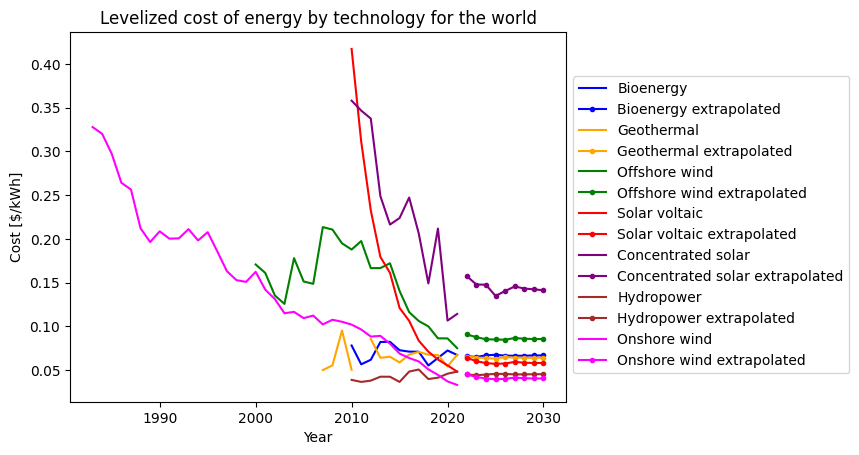

In [ ]:
# visualize extrapolated prices during the years
fig, ax = plt.subplots()

original_data = df_cost_extrapolated.loc[df_cost_extrapolated["Year"] < 2022]
extrapolated = df_cost_extrapolated.loc[df_cost_extrapolated["Year"] >= 2022]

handles = ["Bioenergy", "Bioenergy extrapolated",
           "Geothermal", "Geothermal extrapolated",
           "Offshore wind", "Offshore wind extrapolated",
           "Solar voltaic", "Solar voltaic extrapolated",
           "Concentrated solar", "Concentrated solar extrapolated",
           "Hydropower", "Hydropower extrapolated",
           "Onshore wind", "Onshore wind extrapolated"]
#Bioenergy
ax.plot (original_data.iloc[:,0], original_data.iloc[:, 1:2], "blue")
ax.plot (extrapolated.iloc[:,0], extrapolated.iloc[:, 1:2], "blue", marker = ".")
# Geothermal
ax.plot (original_data.iloc[:,0], original_data.iloc[:, 2:3], "orange")
ax.plot (extrapolated.iloc[:,0], extrapolated.iloc[:, 2:3], "orange", marker = ".")
# Offshore wind
ax.plot (original_data.iloc[:,0], original_data.iloc[:, 3:4], "green")
ax.plot (extrapolated.iloc[:,0], extrapolated.iloc[:, 3:4], "green", marker = ".")
# Solar voltaic
ax.plot (original_data.iloc[:,0], original_data.iloc[:, 4:5], "red")
ax.plot (extrapolated.iloc[:,0], extrapolated.iloc[:, 4:5], "red", marker = ".")
# Concentrated solar
ax.plot (original_data.iloc[:,0], original_data.iloc[:, 5:6], "purple")
ax.plot (extrapolated.iloc[:,0], extrapolated.iloc[:, 5:6], "purple", marker = ".")
# Hydropower
ax.plot (original_data.iloc[:,0], original_data.iloc[:, 6:7], "brown")
ax.plot (extrapolated.iloc[:,0], extrapolated.iloc[:, 6:7], "brown", marker = ".")
# Onshore wind
ax.plot (original_data.iloc[:,0], original_data.iloc[:, 7:8], "magenta")
ax.plot (extrapolated.iloc[:,0], extrapolated.iloc[:, 7:8], "magenta", marker = ".")

# plt.plot(years, values)
ax.legend(handles, bbox_to_anchor = (1, 0.9))

ax.set_ylabel("Cost [$/kWh]")
ax.set_xlabel("Year")
# ax.set_title(f"Levelized cost of energy by technology for the world")

plt.savefig("graph_extrapolated_costs.png", transparent = False, facecolor = "white", bbox_inches = "tight")

# PDF report

In [ ]:
class PDF(FPDF):
    def header(self):
        # Logo
        # self.image('logo_pb.png', 10, 8, 33)
        # Arial bold 15
        self.set_font('Arial', 'B', 15)
        # Move to the right
        self.cell(80)
        # Title
        self.cell(30, 10, "", 0, 0, 'C')
        # Line break
        self.ln(20)
    # Page footer
    def footer(self):
        if self.page_no() != 1:
          # Go to 1.5 cm from bottom
          self.set_y(-15)
          # Select Arial italic 8
          self.set_font('Arial', 'I', 8)
          # Print centered page number
          self.cell(0, 10, 'Page %s' % self.page_no(), 0, 0, 'C')

# Origin of pdf
pdf = PDF("P", "mm", "A4")

# Add first page to pdf
pdf.add_page()
# margin
margin = 25
# page with (A4)
pw = 210 - (2 * margin)
# Cell height
ch = 5


# Doc title
pdf.set_font("Arial", "B", 28)
pdf.cell(w = 0, h = 200, txt = "CO2 emisions", ln = 2, align= "C")

# Doc date
pdf.set_font("Arial", "", 12)
pdf.cell(w = pw/2, h = ch, txt = "", ln = 0)
pdf.cell(w = pw/4, h = ch, txt = "Date:    ", ln = 0, align = "R")
pdf.cell(w = pw/4, h = ch, txt = "19-9-2023", ln = 1)

# Doc author
pdf.set_font("Arial", "", 12)
pdf.cell(w = pw/2, h = ch, txt = "", ln = 0)
pdf.cell(w = pw/4, h = ch, txt = "Author: ", ln = 0, align = "R")
pdf.cell(w = pw/4, h = ch, txt = "Petra Hartman", ln = 1)

# Introduction
pdf.add_page()
pdf.set_font("Arial", "B", 14)
pdf.cell(w = 0 , h = ch, txt = "Introduction", ln=1)
pdf.set_font("Arial", "", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = """This is a report regarding the CO2 emissions. Goal of this report is to answer the following questions:
1.\tWhat is the biggest predictor of a large CO2 output per capita of a country?
2.\tWhich countries are making the biggest strides in decreasing CO2 output?
3.\tWhich non-fossil fuel energy technology will have the best price in the future?

In this report you will find the method used to achieve these results, the results and the conclusion drawn from these results.

""")

# Method
pdf.set_font("Arial", "B", 14)
pdf.cell(w = 0 , h = ch, txt = """Method""", ln=1)

# Method 1. Biggest predictor
pdf.set_font("Arial", "B", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = "\nWhat is the biggest predictor of a large CO2 output per capita of a country?")
pdf.set_font("Arial", "", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = f"""To determine the biggest predictors for a high CO2 output per capita for a country the decision is made to only use the CO2 emissions that are available per capita. Exeption is the GDP that will be converted to the GDP per capita.
1)\tCheck if the variables are distributed normaly with the Shapiro-Wilk test.
2)\tIf the variables are not distributed normaly: normalize the data.
3)\tDetermine the Pearson correlation coefficient and corresponding P-value for all factors versus the {df_pearsonr.iloc[0, 0]}.
4)\tExclude all Pearson correlation coefficients with a P-value higher than 0.05%.
5)\tDetermine the 3 variables that have a high correlation to the {df_pearsonr.iloc[0, 0]}. Meaning that when the variable has a high value, the {df_pearsonr.iloc[0, 0]} has a high value as well.
""")

# Method 2. Biggest strides in decreasing CO2 output
pdf.set_font("Arial", "B", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = "\nWhich countries are making the biggest strides in decreasing CO2 output?")
pdf.set_font("Arial", "", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = f"""To determine the countries that made the biggest strides in reducing the CO2 output the decision is made to only use the relative values of CO2 emission. These emissions are exluding land-use change and emissions embedded in traded goods. This to make the data objective and insensitive for the size of the country or population of the country.
The following steps will be taken:
1)\tDetermine and visualise the cummulative CO2 output and the number contributing countries.
2)\tDetermine the CO2 output per country. This is done by formula:
\t\t[CO2 output] = ([CO2 output end period] - [CO2 output max value]) / [CO2 output end period] *100%.
3)\tDetermine the relative CO2 output per capita. This is done by formulas:
\t\t[CO2 output per capita] = ([CO2 output] * 1000000000) / [Population].
\t\t[Relative CO2 output per capita] = [CO2 output per capita end] - [CO2 output per capita max value] / [CO2 output per capita end] * 100
4)\tVisualize the best 5 performing countries of both the relative CO2 output as the relative CO2 output per capita.
5)\tThe countries that are in both conditions the best performing are the countries that made the biggest strides in reducing the CO2 output.
""")

# Method 3.
pdf.set_font("Arial", "B", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = "\nWhich non-fossil fuel energy technology will have the best price in the future?") # Toevoegen!
pdf.set_font("Arial", "", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = """To determine which non-fossil fuel energy technology will have most likely the best price in the future the curernt available data for the several types of energy will be used.
The following steps will be taken:
1) Extrapolate the available data of levelized energy cost (global scale) to 2030, using K-Nearest Neighbours with n = 5 (standard).
2) Plot the original and extrapolated data.
3) Determine the lowest prices in the future

""")

# Results header
pdf.set_font("Arial", "B", 14)
pdf.cell(w = 0 , h = ch, txt = "Results", ln=1)

# Results 1. Biggest predictor.
pdf.set_font("Arial", "B", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = "\nWhat is the biggest predictor of a large CO2 output per capita of a country?")
pdf.set_font("Arial", "", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = f"""At first the data is checked for the normal distrubution according to the Shapiro-Wilkes test, the results are shown in table 1.1.""")
pdf.set_font("Arial", "", 8)
pdf.multi_cell(w = 0, h = ch,
               txt = f"""Table 1.1: Results of the Shapiro-Wilk test.""")
pdf.image("shapiro.png", x = 10, w=170, h=0)
pdf.set_font("Arial", "", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = f"""None of the variables are distributed normally. Since this is needed for the determination of the correlation betweeen variables, the data will be normalized by use of the cube root.
Graph 1.1 shows an example of a variable before and after normalizing.""")
pdf.set_font("Arial", "", 8)
pdf.image("histograms_original_normalized.png", x=10, w=80, h=0)
pdf.multi_cell(w = 0, h = ch,
               txt = f"""Graph 1.1 Original and normalized data""")
pdf.set_font("Arial", "", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = f"""For the normalized data the correlation between the {df_pearsonr.iloc[0, 0]} and other variables is determined according to the Pearson correlation. The variables that have a correlation are plotted in graph 1.2.""")
pdf.set_font("Arial", "", 8)
pdf.image("correlating_factors.png", x=10, w=100, h=0)
pdf.multi_cell(w = 0, h = ch,
               txt = f"""Graph 1.2 correlation with {df_pearsonr.iloc[0,0]}.""")
pdf.set_font("Arial", "", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = f"""The three variables with the highest correlation for predicting a high CO2 output are:
1) {correlating_factor_1}
2) {correlating_factor_2}
3) {correlating_factor_3}.""")

# Results 2. Biggest strides in decreasing CO2 output
pdf.set_font("Arial", "B", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = "\nWhich countries are making the biggest strides in decreasing CO2 output?") # toevoegen
pdf.set_font("Arial", "", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = f"""First the global trend for the CO2 output is visualized in graph 2.1. For this graph the data of all countries that presented measurements was added together.""")
pdf.set_font("Arial", "", 8)
pdf.image("total_emission_per_year.png", x=10, w=100, h=0)
pdf.multi_cell(w = 0, h = ch,
               txt = f"""Graph 2.1: Total output of CO2 per year and the number of contributing countries""")
pdf.set_font("Arial", "", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = f"""Together it is seen that the CO2 output is rising each year, even after the number of contributing countries has stabilized.
Next the reduction per country is calculated and visualized for the best 5. In order to even out the size of the country the data is given in CO2 output per country [%] (graph 2.2) and CO2 output per capita of a country [%]""")
pdf.set_font("Arial", "", 8)
pdf.image("graph_reduction_%.png", x=10, w=80, h=0)
pdf.multi_cell(w = 0, h = ch,
               txt = f"""Graph 2.2: The 5 best performing countries on CO2 reduction per capita.""")
pdf.set_font("Arial", "", 8)
pdf.image("graph_reduction_capita_%.png", x=10, w=80, h=0)
pdf.multi_cell(w = 0, h = ch,
               txt = f"""Graph 2.3: The 5 best performing countries on CO2 reduction.""")
pdf.set_font("Arial", "", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = f"""The best performing countries in CO2 output reduction are:
               - {best_performing_1}
               - {best_performing_2}
               """)

# results 3.
pdf.set_font("Arial", "B", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = "\nWhich non-fossil fuel energy technology will have the best price in the future?") # Toevoegen!
pdf.set_font("Arial", "", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = """In graph 3.1 the original and extrapolated data for the several energy technologies are plotted""")
pdf.set_font("Arial", "", 8)
pdf.image("graph_extrapolated_costs.png", x=10, w=100, h=0)
pdf.multi_cell(w = 0, h = ch,
               txt = f"""Graph 3.1: Original and extrapolated data for the different energy technologies.""")
pdf.set_font("Arial", "", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = """The three non-fossil energy technologies that have most likely the lowest price in the future are:
1) Onshore wind energy
2) Hydropower energy
3) Solar voltaic energy

""")

# Conclusion header
pdf.set_font("Arial", "B", 14)
pdf.cell(w = 0 , h = ch, txt = "Conclusions", ln=1)

# Conclusion 1. Biggest predictor
pdf.set_font("Arial", "B", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = "\nWhat is the biggest predictor of a large CO2 output per capita of a country?")
pdf.set_font("Arial", "", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = f"""The three variables with the highest correlation for predicting a high CO2 output are:
1) {correlating_factor_1}
2) {correlating_factor_2}
3) {correlating_factor_3}.
""")

# Conclusion 2. Biggest strides in decreasing CO2 output
pdf.set_font("Arial", "B", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = "\nWhich countries are making the biggest strides in decreasing CO2 output?")
pdf.set_font("Arial", "", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = f"""The best performing countries in CO2 output reduction are:
- {best_performing_1}
- {best_performing_2}
""")

# Conclusion 3.
pdf.set_font("Arial", "B", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = "\nWhich non-fossil fuel energy technology will have the best price in the future?")
pdf.set_font("Arial", "", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = """The three non-fossil energy technologies that have most likely the lowest price in the future are:
1) Onshore wind energy
2) Hydropower energy
3) Solar voltaic energy

""")

# Sources
pdf.set_font("Arial", "B", 14)
pdf.multi_cell(w = 0, h = ch,
               txt = "Sources")
pdf.set_font("Arial", "", 11)
pdf.multi_cell(w = 0, h = ch,
               txt = """https://ourworldindata.org/co2-and-greenhouse-gas-emissions
https://github.com/owid/co2-data
https://data-affinity.nl/statistiek/sterkte-van-een-verband-bepalen.html
https://www.statology.org/normality-test-python/
https://ourworldindata.org/grapher/levelized-cost-of-energy """)

# output:
pdf.output ("CO2_emissions.pdf", "F") # Naam aanpassen aan titel document

''